##  Environment Setup

In [2]:
# Basic libraries
import os
import io
import random
import textwrap

# Environment
from dotenv import load_dotenv

# OpenAI and Whisper
import openai
from openai import OpenAI
import whisper

# YouTube download
import yt_dlp

# Audio recording and processing
import sounddevice as sd
import numpy as np
from scipy.io.wavfile import write

# Image processing
from PIL import Image

# OCR
import easyocr

# PDF handling
import fitz  # PyMuPDF

# Widgets for interface
import ipywidgets as widgets
from IPython.display import display

# LangChain and Chroma
import chromadb
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from chromadb.config import Settings




### LangChain Settings

In [3]:
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

In [4]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Taminni_Final_Project" 
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

## 1.YouTube Health Video Transcription and Question Answering Assistant (RAG & Langchain)

#####  Step 1.1 YouTube Input and Transcription Processing

In [8]:
# Initialize OpenAI Client
client = OpenAI()

# Functions

# Download audio from YouTube
def download_audio_from_youtube(youtube_url, output_filename="audio.mp3"):
    try:
        ydl_opts = {
            'format': 'bestaudio/best',
            'outtmpl': output_filename,
            'quiet': True,
        }
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([youtube_url])
        print(f"Audio downloaded successfully to {output_filename}")
        return output_filename
    except Exception as e:
        print(f"Error downloading audio: {e}")
        return None

# Transcribe audio
def transcribe_audio(audio_path, model_size="small"):
    try:
        model = whisper.load_model(model_size)
        result = model.transcribe(audio_path)
        print("Transcription completed successfully.")
        return result["text"]
    except Exception as e:
        print(f"Error during transcription: {e}")
        return None

# Simplify text using OpenAI
def simplify_text(transcribed_text, model_name="gpt-4"):
    try:
        system_prompt = "You are a helpful assistant. Simplify the following health information into easy, clear language for general people. Use short sentences."
        
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": transcribed_text}
            ],
            temperature=0.7,
        )
        simplified_text = response.choices[0].message.content
        print("Simplification completed successfully.")
        return simplified_text
    except Exception as e:
        print(f"Error during simplification: {e}")
        return None

# Build LangChain RAG system
import shutil
import os

def build_rag_system(text, db_path="chroma_final"):
    # Optional: Clean up old Chroma DB directory to avoid corruption issues
    if os.path.exists(db_path):
        shutil.rmtree(db_path, ignore_errors=True)

    # 1. Split text into chunks
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    docs = splitter.create_documents([text])

    # 2. Embed chunks using OpenAI
    embeddings = OpenAIEmbeddings()

    # 3. Store in Chroma vector DB
    vectorstore = Chroma.from_documents(docs, embedding=embeddings, persist_directory=db_path)

    # 4. Create RetrievalQA chain
    retriever = vectorstore.as_retriever()
    qa_chain = RetrievalQA.from_chain_type(llm=ChatOpenAI(), retriever=retriever)

    return qa_chain


# Record audio from microphone
def record_voice_input(filename="voice_input.wav", duration=5, fs=16000):
    print(f"\nRecording for {duration} seconds... Speak now!")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='int16')
    sd.wait()
    write(filename, fs, recording)
    print("Recording finished.")
    return filename

# Transcribe voice input
def transcribe_voice_input(filename, model_size="small"):
    model = whisper.load_model(model_size)
    result = model.transcribe(filename)
    return result["text"]

# Main Question Loop with Text and Voice Options
def ask_questions(qa_chain):
    print("\nYou can now ask questions about the video content.")
    print("Choose:")
    print("1 - Type your question")
    print("2 - Speak your question (voice input)")
    print("Type 'exit' to finish.")

    while True:
        method = input("\nChoose method (1 for text, 2 for voice, exit to stop): ").strip().lower()
        
        if method == "exit":
            print("\nThank you for using the assistant.")
            return "exit"

        if method == "1":
            question = input("Type your question: ")
        elif method == "2":
            audio_file = record_voice_input()
            question = transcribe_voice_input(audio_file)
            print(f"\nYou said: {question}")
        else:
            print("Invalid choice. Please select 1 or 2 or 'exit'.")
            continue

        if question.strip().lower() == "exit":
            print("\nThank you for using the assistant.")
            return "exit"

        # Print the question before the answer
        print(f"\nQuestion: {question}")
        answer = qa_chain.run(question)
        print("\nAnswer:")
        print(textwrap.fill(answer, width=100))

#####  1.2 Display Transcription and Answring Questions

In [ ]:
import os
import textwrap

# Step 1: User Input
youtube_url = input("Paste your YouTube video link here (or type 'exit' to quit): ").strip()

# Case 1: Exit before anything starts
if youtube_url.lower() == "exit":
    print("Session ended before starting.")

    #  Try deleting audio just in case it exists from a previous run
    if os.path.exists("audio.mp3"):
        os.remove("audio.mp3")
        print("Audio file deleted.")
else:
    # Step 2: Download and Transcribe
    audio_path = download_audio_from_youtube(youtube_url)

    if audio_path:
        transcription = transcribe_audio(audio_path)

        if transcription:
            print("\nFull Detailed Transcript:")
            print("="*50)
            print(textwrap.fill(transcription, width=100))
            final_text = transcription

            # Step 3: Build RAG and Ask Questions
            print("\nBuilding retrieval system...")
            qa_chain = build_rag_system(final_text)

            if qa_chain:
                result = ask_questions(qa_chain)

                # Case 2: Exit during Q&A — delete audio
                if os.path.exists(audio_path):
                    os.remove(audio_path)
                    print("✅ Audio file deleted.")

                if result == "exit":
                    print("Session ended by user.")
            else:
                print("Failed to build question answering system.")
    else:
        print("Failed to download or process the video.")

Audio downloaded successfully to audio.mp3               


/opt/anaconda3/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcription completed successfully.

Full Detailed Transcript:
 There are two main types of diabetes. Type 1 and type 2. They're different conditions but they're
both serious. There are some other rarer types of diabetes too. What all types of diabetes have in
common is that they cause people to have too much glucose in their blood but we all need some
glucose. It's what gives us our energy. We get glucose when our bodies break down the carbohydrates
that we eat or drink and that glucose is released into our blood. We also need a hormone called
insulin. It's made by our pancreas and it's insulin that allows the glucose in our blood to enter
our cells and fuel our bodies. If you don't have diabetes your pancreas senses when glucose has
entered your bloodstream and releases the right amount of insulin so the glucose can get into your
cells. But if you have diabetes this system doesn't work. When you've got type 1 diabetes you can't
make any insulin at all. If you've got type 2 diabetes

In [10]:
migraine_video_text = """
This animation is brought to you by the Association of Migraine Disorders. Migraine is not just a
headache. It's a complex neurological disease that impacts more than one billion people worldwide.
You can learn more about migraine at www.migrainedisorders.org. To sense our world, your nerves send
electrical signals to and from your spinal cord and brain. Sensors throughout our body collect
information about our surroundings. This information is sent by signals to our brain through a
series of nerve cells. Each electrical signal is carried from one end of a nerve cell to the other
using passageways called ion channels. Charged particles, called ions, pass through the channels
along the nerve, which helps generate the electrical current. At the end of the nerve, the signal
moves to the next via chemicals called neurotransmitters. Communication with the brain occurs via
pathways and nerve centers at the base of the brain, called the brainstem. The brainstem helps
control sleep, heart rate, and breathing. Migraine is a disease where one or more parts of this
communication system does not function properly. Many sections of DNA, called genes, program ion
channels, neurotransmitters, and other structures that support these nerve pathways. In some with
migraine, inherited changes to genes, called mutations, can cause the communication system to become
hypersensitive. Most mutations do not directly cause migraine, but, in combination, may explain why
there are so many forms and symptoms of migraine disease. These mutated genes affect the function of
other parts of the body. As a result, people with migraines may also have anxiety, depression,
epilepsy, hypothyroidism, irritable bowel syndrome, pelvic floor pain, fibromyalgia, chogren's
disease, and others. Each attack typically has three or four phases. The typical phases of a
migraine attack are pro-drome, starting hours before a headache, aura, headache, and post-drome.
Pro-drome includes subtle symptoms such as yawning, fatigue, or moodiness. Experienced only by some,
...
Remember, while certain risk factors such as genetics can't be changed, lifestyle modifications can
significantly reduce the risk of heart attacks.

"""


## 2.Build File Uploders (Images, PDF, Voice Notes)

##### 2.1 Build file uploader for PDF 

 2.1.1 Extract Text and Display Report

In [13]:
# Upload Widget for PDFs
pdf_upload = widgets.FileUpload(accept='.pdf', multiple=False)
display(pdf_upload)

# Save Uploaded PDF
def save_uploaded_pdf(upload_widget):
    if upload_widget.value:
        uploaded_file = list(upload_widget.value.values())[0]
        uploaded_filename = uploaded_file['metadata']['name']
        content = uploaded_file['content']
        with open(uploaded_filename, 'wb') as f:
            f.write(content)
        return uploaded_filename
    else:
        return None

# Extract Text from PDF
def extract_text_from_pdf(file_path):
    doc = fitz.open(file_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

# Handle Uploaded PDF
def handle_pdf_upload(upload_widget):
    file_path = save_uploaded_pdf(upload_widget)  
    if not file_path:
        print("No file uploaded.")
        return None

    if file_path.lower().endswith('.pdf'):
        print("Processing PDF...")
        text = extract_text_from_pdf(file_path)
        print("\nExtracted Text from PDF:")
        print("="*50)
        print(text)
        return text  # Return the extracted text
    else:
        print("Unsupported file type for PDF text extraction.")
        return None


FileUpload(value={}, accept='.pdf', description='Upload')

In [14]:
extracted_text = handle_pdf_upload(pdf_upload)

Processing PDF...

Extracted Text from PDF:
Printed Date: 24/10/2024 09:48 AM
Page 1 of 2
Verified by: null
www.moh.gov.sa
937
SaudiMOH
المختبر فحوصات نتائج | Lab Test Results
Patient Name
: AL******* **** ******** *******
Requesting Facility
: ALSEHILI PRIMARY HEALTH CARE
Id/Iqama No.
: ******9228
Lab Name
: KING FAISAL MEDICAL COMPLEX
Order provider
: SA**** ***** ******** **********
Order Date
:
Order Number
: 97************
Result Date
: 2024-10-24 09:48 AM
Test Name
Result
Unit
Ref. Ranges
CBC W/ AUTO
DIFFERENTIAL
Platelets [#/volume] in Blood
by Automated count
378
[150-410]
Basophils/100 leukocytes in
Blood by Automated count
1.3
%
[0-1]
Eosinophils/100 leukocytes in
Blood by Automated count
3.2
%
[1-6]
HEMATOCRIT
.4
L/L
[0.36-0.48]
Hemoglobin [Mass/volume] in
Blood
140
g/L
[120-160]
Lymphocytes/100 leukocytes
in Blood by Automated count
39.4
%
[20-40]
MCH [Entitic mass] by
Automated count
30.2
pg
[27-32]
MCHC [Mass/volume] by
Automated count
338
g/L
[315-345]
MCV [Entitic volum

 2.2.2 Generate Advice

In [15]:
# Initialize OpenAI client
client = OpenAI()

# Analyze Extracted Text for Health Advice
def analyze_health_report(extracted_text, model_name="gpt-4"):
    try:
        system_prompt = (
            "You are a helpful health assistant. Read the following text extracted from a medical report. "
            "Identify any deficiencies or health problems. Give clear, practical advice without diagnosing, "
            "based on the findings. Suggestions should be easy to follow."
        )
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": extracted_text}
            ],
            temperature=0.7,
        )
        advice_text = response.choices[0].message.content
        return advice_text
    except Exception as e:
        print(f"Error during health advice generation: {e}")
        return None

# Generate and Display Advice
if extracted_text:
    advice = analyze_health_report(extracted_text)
    
    print("\nHealth Advice based on the Report:")
    print("="*50)
    print(textwrap.fill(advice, width=100))
else:
    print("No extracted text available for analysis.")



Health Advice based on the Report:
The lab results indicate that the patient's blood test results are largely within the normal
reference ranges. This generally suggests healthy blood and immune function. However, the percentage
of Basophils in the blood is slightly elevated beyond the normal range.   Basophils are a type of
white blood cell that plays a role in the body's immune response. Elevated levels can sometimes be
associated with certain conditions such as allergies, infection, or inflammation.  While it's not
possible to make a diagnosis based on this result alone, it may be beneficial for the patient to
follow a few health guidelines:  1. Continue to monitor any signs of infection or inflammation such
as fever, fatigue, body aches, or redness and swelling in any part of the body.   2. Maintain a
balanced diet rich in fruits, vegetables, lean proteins, and whole grains to support overall health
and immune function.  3. Regular exercise can also help boost the immune system an

##### 3.3 Build file uploader for audio (voice notes upload)

3.3.1 Extract from Voice Note

In [20]:
# Initialize OpenAI Client 
client = OpenAI()

# Upload Widget for Audio 
audio_upload = widgets.FileUpload(accept='.mp3, .wav, .m4a', multiple=False)
display(audio_upload)

# Save Uploaded Audio 
def save_uploaded_audio(upload_widget):
    if upload_widget.value:
        uploaded_file = list(upload_widget.value.values())[0]
        uploaded_filename = uploaded_file['metadata']['name']
        content = uploaded_file['content']
        
        with open(uploaded_filename, "wb") as f:
            f.write(content)
        return uploaded_filename
    return None


# Transcribe Audio
def transcribe_uploaded_audio(file_path, model_size="small"):
    try:
        model = whisper.load_model(model_size)
        result = model.transcribe(file_path)
        print("\nTranscription completed successfully:")
        print("="*50)
        wrapped_text = textwrap.fill(result['text'], width=100) 
        print(wrapped_text)
        return result['text']
    except Exception as e:
        print(f"Error during transcription: {e}")
        return None


# Handle Audio Upload
def handle_audio_upload(upload_widget):
    file_path = save_uploaded_audio(upload_widget)  
    if not file_path:
        print("No audio file uploaded.")
        return None

    if file_path.lower().endswith(('.mp3', '.wav', '.m4a')):
        print("Processing audio file...")
        transcribed_text = transcribe_uploaded_audio(file_path)
        return transcribed_text
    else:
        print("Unsupported file type for audio transcription.")
        return None

FileUpload(value={}, accept='.mp3, .wav, .m4a', description='Upload')

In [21]:
transcribed_text = handle_audio_upload(audio_upload)

Processing audio file...


/opt/anaconda3/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")



Transcription completed successfully:
 Hello, this is Dr. Smith, I reviewed your blood tests. And it looks like you have iron deficiency.
To help improve your iron levels, I recommend that you increase your intake of iron-rich foods, such
as red meat, spinach, lentils, and fortified cereals. It's important to pair these foods with
vitamin C sources like oranges or bell peppers to help with absorption. Also, please avoid drinking
tea or coffee immediately after meals. As they can reduce iron absorption. I'm prescribing you a
daily iron supplement. Make sure to take it with food to reduce stomach upset. If you feel dizzy,
extremely tired, or short of breath, contact my office right away. We'll repeat your blood work in
about eight weeks to monitor your progress. Take care and don't hesitate to reach out if you have
any questions.


 3.3.2 Generate Advice

In [22]:
# ===== Analyze Extracted Text for Health Advice =====
def analyze_health_report(extracted_text, model_name="gpt-4"):
    try:
        system_prompt = (
            "You are a helpful health assistant. Read the following text extracted from a doctor's voice note. "
            "Identify any deficiencies or health problems. Give clear, practical advice without diagnosing, "
            "based on the findings. Suggestions should be easy to follow and friendly."
        )
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": extracted_text}
            ],
            temperature=0.7,
        )
        advice_text = response.choices[0].message.content
        return advice_text
    except Exception as e:
        print(f"Error during health advice generation: {e}")
        return None

# ===== Automatically Analyze Transcription After Upload =====
if transcribed_text:
    advice = analyze_health_report(transcribed_text)
    if advice:
        print("\nHealth Advice Based on Doctor's Voice Note:")
        print("="*50)
        print(textwrap.fill(advice, width=100))
    else:
        print("Failed to generate health advice.")
else:
    print("No transcription available to analyze.")



Health Advice Based on Doctor's Voice Note:
It appears you have an iron deficiency, which can lead to symptoms like dizziness, extreme
tiredness, or shortness of breath. Here are some simple steps you can take to help improve your iron
levels:  1. Include more iron-rich foods in your diet. Good sources of iron include red meat,
spinach, lentils, and fortified cereals.  2. Pair your iron-rich foods with vitamin C sources. Foods
like oranges and bell peppers can help your body absorb iron better.  3. Try to avoid drinking tea
or coffee immediately after meals. These beverages can decrease your body's ability to absorb iron.
4. Your doctor has prescribed a daily iron supplement. Remember to take it with food to prevent any
potential stomach discomfort.  5. Stay vigilant about any symptoms such as dizziness, extreme
tiredness, or shortness of breath. If you experience any of these, get in touch with your doctor
immediately.  In about eight weeks, you'll have another blood test to check yo

## 3.Image Classification With GPT-4o

## 📤 Upload a skin or medical image:

Dropdown(description='Type:', options=('Skin Condition', 'General Medical Condition'), value='Skin Condition')

FileUpload(value={}, accept='image/*', description='Upload')

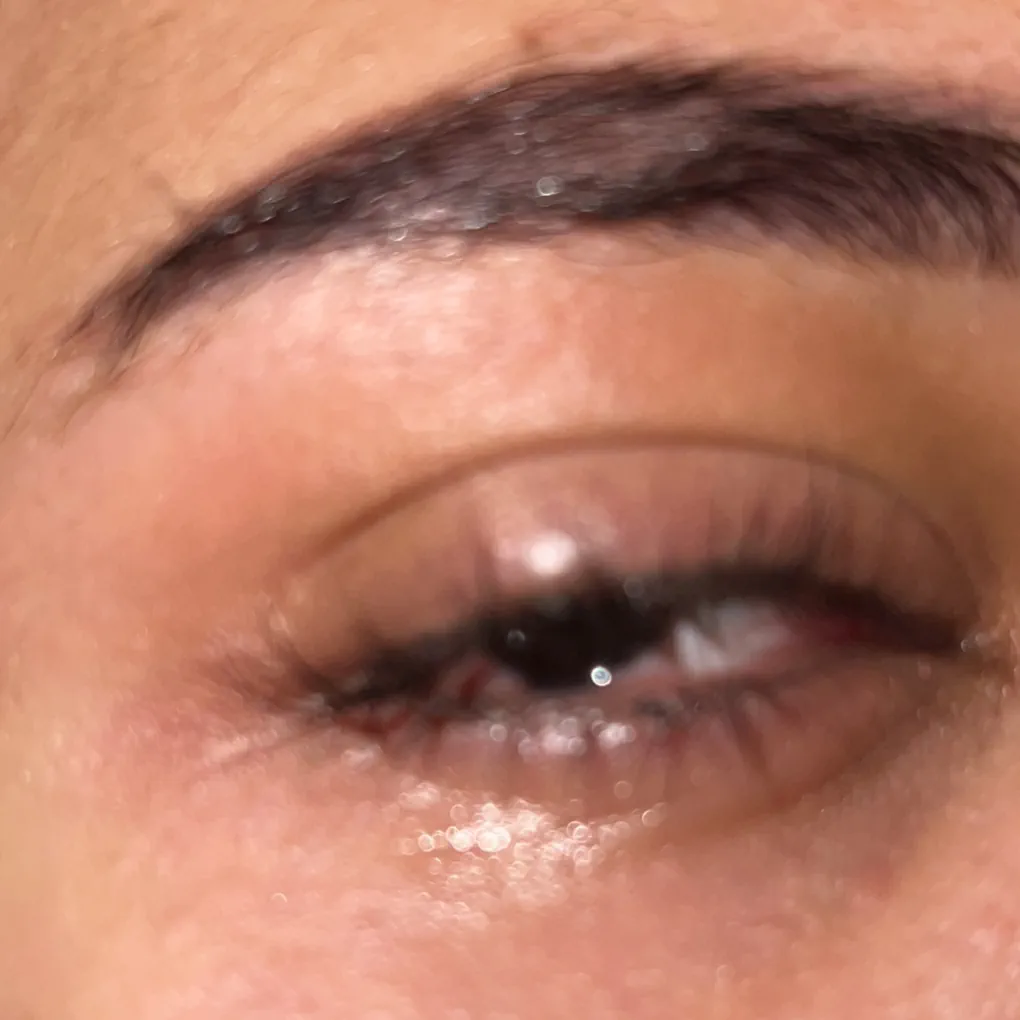

### 🤖 GPT-4o Analysis:
I'm unable to provide a detailed assessment based on this image alone. However, if you notice any redness, swelling, or discharge around the eye, it could potentially be a sign of irritation or an eye condition like conjunctivitis. If there's dryness or scaling on the eyelid, it might indicate a skin issue like eczema or dermatitis.

For an accurate diagnosis, it's best to consult a healthcare professional.


> **⚕️ Important Note:**  
This analysis is only a preliminary suggestion. For a confirmed diagnosis and treatment plan, it is highly recommended to consult a qualified healthcare provider.


In [23]:
import openai
import base64
import io
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, Markdown


upload_button = widgets.FileUpload(accept='image/*', multiple=False)
condition_type = widgets.Dropdown(
    options=["Skin Condition", "General Medical Condition"],
    description="Type:",
)


def analyze_image(change):
    if upload_button.value:
        
        uploaded_file = list(upload_button.value.values())[0]
        img_data = uploaded_file['content']

        
        image = Image.open(io.BytesIO(img_data))
        display(image)

        
        image_base64 = base64.b64encode(img_data).decode("utf-8")

        
        if condition_type.value == "Skin Condition":
            prompt = """
            You are a helpful medical assistant. Based on this image, describe what kind of skin condition might be shown. 
            Give possible names or categories (like eczema, vitiligo, rash, etc.), but mention this is not a medical diagnosis.
            Use clear and simple language.
            """
        else:  
            prompt = """
            You are a helpful medical assistant. Based on this image, describe any visible signs of a medical condition. 
            This can include skin issues (eczema, rash, vitiligo), eye conditions (redness, swelling, discharge), burns, wounds, or any other visible symptoms. 
            Provide possible names or categories, but make it clear this is not a medical diagnosis.
            Use clear, simple language suitable for general understanding.
            """

        
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "user", "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}}
                ]}
            ],
            max_tokens=500
        )

      
        result = response.choices[0].message.content

   
        display(Markdown(f"### 🤖 GPT-4o Analysis:\n{result}"))

      
        advice = """
> **⚕️ Important Note:**  
This analysis is only a preliminary suggestion. For a confirmed diagnosis and treatment plan, it is highly recommended to consult a qualified healthcare provider.
"""
        display(Markdown(advice))


upload_button.observe(analyze_image, names='value')


display(Markdown("## 📤 Upload a skin or medical image:"))
display(condition_type)
display(upload_button)


## 4.Build Knowledge Base and QA Chain


In [ ]:

import fitz  # PyMuPDF

def load_pdf_text(pdf_path):
    import fitz
    doc = fitz.open(pdf_path)
    raw_text = "\n".join([page.get_text() for page in doc])
    
  
    lines = [line.strip() for line in raw_text.splitlines() if line.strip()]
    merged_lines = []
    temp_line = ""

    for line in lines:
        if line[0].isupper() and temp_line:  
            merged_lines.append(temp_line.strip())
            temp_line = line
        else:
            temp_line += " " + line  

    if temp_line:
        merged_lines.append(temp_line.strip())

    return "\n".join(merged_lines)

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
import shutil


pdf_text = load_pdf_text("/Users/amira/Desktop/طمني/1729752507_VSCqV1d8dR94.pdf")
audio_text = transcribe_audio("/Users/amira/Desktop/طمني/AUDIO-2025-04-28-18-43-57.mp3")
video_text = transcribe_audio("/Users/amira/Desktop/طمني/yt_video_audio.mp3")


combined_text = pdf_text + "\n" + audio_text + "\n" + video_text


splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=100)
texts = splitter.split_text(combined_text)


embedding = OpenAIEmbeddings()
vectorstore_all = Chroma.from_texts(
    texts,
    embedding=embedding,
    collection_name="taminni_full1",
    persist_directory="./chroma_TaminniFull1"
)
vectorstore_all.persist()

/opt/anaconda3/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcription completed successfully.


/opt/anaconda3/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcription completed successfully.


#### Precision@3 Evaluation

In [95]:
def precision_at_k(query, ideal_chunk, retriever, k=3):
    retrieved_docs = retriever.get_relevant_documents(query)[:k]
    for doc in retrieved_docs:
        if ideal_chunk in doc.page_content:
            return 1.0
    return 0.0

In [ ]:
evaluation_data_all = [
    # PDF
    {
        "query": "What is the platelet count?",
        "ideal_chunk": "Platelets [#/volume] in Blood by Automated count 378"
    },
    {
        "query": "What is the hemoglobin level?",
        "ideal_chunk": "Hemoglobin [Mass/volume] in Blood 140 g/L"
    },

    # (voice note)
    {
        "query": "What did the doctor say about iron?",
        "ideal_chunk": "it looks like you have iron deficiency"
    },
    {
        "query": "What did the doctor recommend for better iron absorption?",
        "ideal_chunk": "pair these foods with vitamin C sources like oranges or bell peppers"
    },

    #(YouTube)
    {
        "query": "What causes migraine disease?",
        "ideal_chunk": "Migraine is a disease where one or more parts of this communication system does not function properly"
    },
    {
        "query": "What are the phases of a migraine?",
        "ideal_chunk": "The typical phases of a migraine attack are pro-drome, starting hours before a headache, aura, headache, and post-drome"
    }
]

In [102]:
results_all = []
for example in evaluation_data_all:
    score = precision_at_k(example["query"], example["ideal_chunk"], vectorstore_all.as_retriever(), k=3)
    results_all.append({
        "query": example["query"],
        "precision@3": score
    })

import pandas as pd
pd.DataFrame(results_all)

,query,precision@3
0,What is the platelet count?,1.0
1,What is the hemoglobin level?,0.0
2,What did the doctor say about iron?,1.0
3,What did the doctor recommend for better iron ...,1.0
4,What causes migraine disease?,1.0
5,What are the phases of a migraine?,1.0


## 5. Define Agent Tools
Tools for PDF, YouTube, and Audio notes.

In [57]:
import openai
import whisper
import fitz  # PyMuPDF
from langchain.agents import Tool, initialize_agent, AgentType
from langchain.chat_models import ChatOpenAI

# Tool 1: Whisper 
def transcribe_audio_file(audio_path):
    model = whisper.load_model("base")  
    result = model.transcribe(audio_path)
    return result["text"]

# Tool 2: PDF 
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

#  Tool 3: qa_chain 
from langchain.chains import RetrievalQA
qa_chain = RetrievalQA.from_chain_type(llm=ChatOpenAI(model="gpt-4"), retriever=your_vectorstore.as_retriever())

# (Tools) 
speech_to_text_tool = Tool(
    name="Audio Transcriber",
    func=transcribe_audio_file,
    description="Transcribe spoken audio files to text using Whisper."
)

pdf_extraction_tool = Tool(
    name="PDF Text Extractor",
    func=extract_text_from_pdf,
    description="Extract text from uploaded PDF files."
)

retrieval_tool = Tool(
    name="Knowledge Retrieval",
    func=qa_chain.run,  
    description="Answer questions from the knowledge base."
)

tools = [speech_to_text_tool, pdf_extraction_tool, retrieval_tool]

### 5.1 Agent Definition

In [58]:
agent = initialize_agent(
    tools=tools,
    llm=ChatOpenAI(model_name="gpt-4"),
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

In [59]:
from langsmith import traceable
@traceable(name="Taminni Agent Run")
def run_agent_with_logging(query):
    return agent.invoke(query)

### 5.2 Main Execution Example

In [60]:
agent.invoke("Summarize the results of this medical lab report. /Users/amira/Desktop/طمني/1729752507_VSCqV1d8dR94.pdf")




> Entering new AgentExecutor chain...
The question is asking to summarize a medical lab report which is in a PDF format. I need to extract the text from the PDF first.
Action: PDF Text Extractor
Action Input: /Users/amira/Desktop/طمني/1729752507_VSCqV1d8dR94.pdf
Observation: Printed Date: 24/10/2024 09:48 AM
Page 1 of 2
Verified by: null
www.moh.gov.sa
937
SaudiMOH
المختبر فحوصات نتائج | Lab Test Results
Patient Name
: AL******* **** ******** *******
Requesting Facility
: ALSEHILI PRIMARY HEALTH CARE
Id/Iqama No.
: ******9228
Lab Name
: KING FAISAL MEDICAL COMPLEX
Order provider
: SA**** ***** ******** **********
Order Date
:
Order Number
: 97************
Result Date
: 2024-10-24 09:48 AM
Test Name
Result
Unit
Ref. Ranges
CBC W/ AUTO
DIFFERENTIAL
Platelets [#/volume] in Blood
by Automated count
378
[150-410]
Basophils/100 leukocytes in
Blood by Automated count
1.3
%
[0-1]
Eosinophils/100 leukocytes in
Blood by Automated count
3.2
%
[1-6]
HEMATOCRIT
.4
L/L
[0.36-0.48]
Hemoglobin [Mass

{'input': 'Summarize the results of this medical lab report. /Users/amira/Desktop/طمني/1729752507_VSCqV1d8dR94.pdf',
 'output': "The lab report shows several tests results. Most of them, including the Complete Blood Count, Platelets count, Eosinophils count, Hematocrit, Hemoglobin level, Lymphocytes count, Mean Corpuscular Hemoglobin (MCH), Mean Corpuscular Hemoglobin Concentration (MCHC), and Mean Corpuscular Volume (MCV) are within the normal ranges. However, the Basophils count is slightly above the normal range. It's important to consult with a healthcare provider for an accurate interpretation of these results."}

In [61]:
agent.invoke("Explain the findings in this lab report in simple language. /Users/amira/Desktop/طمني/1729752507_VSCqV1d8dR94.pdf")




> Entering new AgentExecutor chain...
The question is asking for a simplified explanation of a lab report. The lab report is in a PDF file. I should extract the text from the PDF to understand the report's content.
Action: PDF Text Extractor
Action Input: /Users/amira/Desktop/طمني/1729752507_VSCqV1d8dR94.pdf
Observation: Printed Date: 24/10/2024 09:48 AM
Page 1 of 2
Verified by: null
www.moh.gov.sa
937
SaudiMOH
المختبر فحوصات نتائج | Lab Test Results
Patient Name
: AL******* **** ******** *******
Requesting Facility
: ALSEHILI PRIMARY HEALTH CARE
Id/Iqama No.
: ******9228
Lab Name
: KING FAISAL MEDICAL COMPLEX
Order provider
: SA**** ***** ******** **********
Order Date
:
Order Number
: 97************
Result Date
: 2024-10-24 09:48 AM
Test Name
Result
Unit
Ref. Ranges
CBC W/ AUTO
DIFFERENTIAL
Platelets [#/volume] in Blood
by Automated count
378
[150-410]
Basophils/100 leukocytes in
Blood by Automated count
1.3
%
[0-1]
Eosinophils/100 leukocytes in
Blood by Automated count
3.2
%
[1-6]

{'input': 'Explain the findings in this lab report in simple language. /Users/amira/Desktop/طمني/1729752507_VSCqV1d8dR94.pdf',
 'output': 'Here is a simple explanation of your lab report: \n\nThe report contains a complete blood count with auto differential. This is a general health check that looks at different components of your blood, including red cells (which carry oxygen), white cells (which fight infection), and platelets (which help with clotting). \n\nThe report shows the counts or percentages of different types of white blood cells, including basophils, eosinophils, lymphocytes, monocytes and neutrophils. These are all different types of cells that help your body fight off infections and diseases.\n\nThe report also shows measurements for hemoglobin, which is a protein in red blood cells that carries oxygen. The amount of hemoglobin in your blood is within the normal range. \n\nMeasurements for MCH, MCHC, and MCV show the average amount of hemoglobin per red cell, the average

In [62]:
agent.invoke("Transcribe this audio file to text: /Users/amira/Desktop/طمني/AUDIO-2025-04-28-18-43-57.mp3")




> Entering new AgentExecutor chain...
The question is asking to transcribe an audio file to text. I have an Audio Transcriber tool that can do this job.
Action: Audio Transcriber
Action Input: /Users/amira/Desktop/طمني/AUDIO-2025-04-28-18-43-57.mp3

/opt/anaconda3/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")



Observation:  Hello, this is Dr. Smith. I reviewed your blood tests. And it looks like you have iron deficiency. To help improve your iron levels, I recommend that you increase your intake of iron-rich foods, such as red meat, spinach, lentils, and fortified cereals. It's important to pair these foods with vitamin C sources like oranges or bell peppers to help with. Absorption. Also, please avoid drinking tea or coffee immediately after meals. As they can reduce iron absorption. I'm prescribing you a daily iron supplement. Make sure to take it with food to reduce stomach upset. If you feel dizzy, extremely tired, or short of breath, contact my office right away. We'll repeat your blood work in about eight weeks to monitor your progress. Take care, and don't hesitate to reach out if you have any questions.
Thought:I have successfully transcribed the audio file to text.
Final Answer: The audio file says: "Hello, this is Dr. Smith. I reviewed your blood tests. And it looks like you have 

{'input': 'Transcribe this audio file to text: /Users/amira/Desktop/طمني/AUDIO-2025-04-28-18-43-57.mp3',
 'output': 'The audio file says: "Hello, this is Dr. Smith. I reviewed your blood tests. And it looks like you have iron deficiency. To help improve your iron levels, I recommend that you increase your intake of iron-rich foods, such as red meat, spinach, lentils, and fortified cereals. It\'s important to pair these foods with vitamin C sources like oranges or bell peppers to help with. Absorption. Also, please avoid drinking tea or coffee immediately after meals. As they can reduce iron absorption. I\'m prescribing you a daily iron supplement. Make sure to take it with food to reduce stomach upset. If you feel dizzy, extremely tired, or short of breath, contact my office right away. We\'ll repeat your blood work in about eight weeks to monitor your progress. Take care, and don\'t hesitate to reach out if you have any questions."'}

In [63]:
agent.invoke("Please convert this recording into written text: /Users/amira/Desktop/طمني/AUDIO-2025-04-28-18-43-57.mp3")




> Entering new AgentExecutor chain...
The question asks to convert a spoken audio file into written text. The appropriate action would be to use the Audio Transcriber tool.
Action: Audio Transcriber
Action Input: /Users/amira/Desktop/طمني/AUDIO-2025-04-28-18-43-57.mp3

/opt/anaconda3/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")



Observation:  Hello, this is Dr. Smith. I reviewed your blood tests. And it looks like you have iron deficiency. To help improve your iron levels, I recommend that you increase your intake of iron-rich foods, such as red meat, spinach, lentils, and fortified cereals. It's important to pair these foods with vitamin C sources like oranges or bell peppers to help with. Absorption. Also, please avoid drinking tea or coffee immediately after meals. As they can reduce iron absorption. I'm prescribing you a daily iron supplement. Make sure to take it with food to reduce stomach upset. If you feel dizzy, extremely tired, or short of breath, contact my office right away. We'll repeat your blood work in about eight weeks to monitor your progress. Take care, and don't hesitate to reach out if you have any questions.
Thought:I now know the final answer
Final Answer: Hello, this is Dr. Smith. I reviewed your blood tests. And it looks like you have iron deficiency. To help improve your iron levels,

{'input': 'Please convert this recording into written text: /Users/amira/Desktop/طمني/AUDIO-2025-04-28-18-43-57.mp3',
 'output': "Hello, this is Dr. Smith. I reviewed your blood tests. And it looks like you have iron deficiency. To help improve your iron levels, I recommend that you increase your intake of iron-rich foods, such as red meat, spinach, lentils, and fortified cereals. It's important to pair these foods with vitamin C sources like oranges or bell peppers to help with. Absorption. Also, please avoid drinking tea or coffee immediately after meals. As they can reduce iron absorption. I'm prescribing you a daily iron supplement. Make sure to take it with food to reduce stomach upset. If you feel dizzy, extremely tired, or short of breath, contact my office right away. We'll repeat your blood work in about eight weeks to monitor your progress. Take care, and don't hesitate to reach out if you have any questions."}

In [64]:
agent.invoke("What is migraine disease?")




> Entering new AgentExecutor chain...
This question is asking for a definition or explanation of a medical condition. I should first check the knowledge base.
Action: Knowledge Retrieval
Action Input: "What is migraine disease?"
Observation: Migraine is a complex neurological disease that impacts more than one billion people worldwide. It's not just a headache, but a condition where one or more parts of the communication system between the nerves, spinal cord, and brain does not function properly. In some people with migraine, inherited changes to genes, called mutations, can cause this communication system to become hypersensitive. This can result in various forms and symptoms of the disease. People with migraines may also have anxiety, depression, epilepsy, hypothyroidism, irritable bowel syndrome, pelvic floor pain, fibromyalgia, chogren's disease, and others. Each migraine attack typically has three or four phases.
Thought:I now know the final answer.
Final Answer: Migraine is a 

{'input': 'What is migraine disease?',
 'output': "Migraine is a complex neurological disease that impacts more than one billion people worldwide. It's not just a headache, but a condition where one or more parts of the communication system between the nerves, spinal cord, and brain does not function properly. In some people with migraine, inherited changes to genes, called mutations, can cause this communication system to become hypersensitive. This can result in various forms and symptoms of the disease. People with migraines may also have anxiety, depression, epilepsy, hypothyroidism, irritable bowel syndrome, pelvic floor pain, fibromyalgia, chogren's disease, and others. Each migraine attack typically has three or four phases."}

In [65]:
agent.invoke("Why might people with migraines experience other health issues like depression or IBS?")




> Entering new AgentExecutor chain...
This question requires medical knowledge. I should use the Knowledge Retrieval tool.
Action: Knowledge Retrieval
Action Input: "Why might people with migraines experience other health issues like depression or IBS?"
Observation: People with migraines might experience other health issues like depression or IBS because the mutated genes that contribute to migraines can also affect the function of other parts of the body. This can result in a variety of other conditions and symptoms.
Thought:I now know the final answer
Final Answer: People with migraines might experience other health issues like depression or IBS because the mutated genes that contribute to migraines can also affect the function of other parts of the body. This can result in a variety of other conditions and symptoms.

> Finished chain.


{'input': 'Why might people with migraines experience other health issues like depression or IBS?',
 'output': 'People with migraines might experience other health issues like depression or IBS because the mutated genes that contribute to migraines can also affect the function of other parts of the body. This can result in a variety of other conditions and symptoms.'}

## 6.Evaluator & Hallucination Detection

In [162]:
from fuzzywuzzy import fuzz
import pandas as pd

examples = [
    {
        "question": "What causes migraine?",
        "prediction": "Migraines are caused by stress, lack of sleep, and brain changes.",
        "retrieved_docs": "Migraines may be caused by genetic mutations and changes in the brain."
    },
    {
        "question": "What is the function of red blood cells?",
        "prediction": "Red blood cells transport oxygen and remove carbon dioxide.",
        "retrieved_docs": "Red blood cells carry oxygen from the lungs to tissues and remove CO2."
    },
    {
        "question": "What is the cure for cancer?",
        "prediction": "Cancer can be cured by drinking herbal tea daily.",
        "retrieved_docs": "There is no universal cure for cancer. Treatments include chemotherapy, radiation, and surgery."
    },
    {
        "question": "Why might people with migraines experience other health issues like depression or IBS?",
        "prediction": "People with migraines might experience other health issues like depression or IBS because the mutated genes that contribute to migraines can also affect the function of other parts of the body. This can result in a variety of other conditions and symptoms.",
        "retrieved_docs": "These mutated genes affect the function of other parts of the body. As a result, people with migraines may also have anxiety, depression, epilepsy, hypothyroidism, irritable bowel syndrome, pelvic floor pain, fibromyalgia, Sjogren's disease, and others."
    }
]
results = []
for ex in examples:
    pred = ex["prediction"].lower()
    docs = ex["retrieved_docs"].lower()
    similarity = fuzz.token_set_ratio(pred, docs)

 
    if similarity >= 50:
        hallucinated = "No"
    elif 45 <= similarity < 75:
        hallucinated = "Maybe"
    else:
        hallucinated = "Yes"

    results.append({
        "question": ex["question"],
        "prediction": ex["prediction"],
        "retrieved_docs": ex["retrieved_docs"],
        "similarity (%)": similarity,
        "hallucination?": hallucinated
    })


df = pd.DataFrame(results)
display(df)


,question,prediction,retrieved_docs,similarity (%),hallucination?
0,What causes migraine?,"Migraines are caused by stress, lack of sleep,...",Migraines may be caused by genetic mutations a...,75,No
1,What is the function of red blood cells?,Red blood cells transport oxygen and remove ca...,Red blood cells carry oxygen from the lungs to...,73,No
2,What is the cure for cancer?,Cancer can be cured by drinking herbal tea daily.,There is no universal cure for cancer. Treatme...,46,Maybe
3,Why might people with migraines experience oth...,People with migraines might experience other h...,These mutated genes affect the function of oth...,67,No
